# Week 12

More Tensors and Neural Networks

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from torch import nn, Tensor

from data_utils import object_from_json_url
from data_utils import StandardScaler

## More Tensors and Why They're Awesome

Multi-dimensional slicing is definitely a nice property of tensors, but what really sets them apart from fancy lists is their ability to keep track of all the operations performed on them using _computational graphs_.

If we define a tensor and set its `requires_grad` parameter to `True` we unlock some really nice properties that we can use for training neural networks.

One of these properties is the ability to automatically calculate derivatives (OMG, calculus!) of functions defined in terms of our tensor.

Let's investigate.

### Easy Calculus and Free Derivatives

Let's pretend we have the following function:

$f(x) = x^4 - 0.7x^3 - 2x^2 + x + 1$

And we want to find out when the function achieves its minimum values.

We can plot it, and easily approximate those values visually:

In [3]:
def peaks(x):
  return x**4 - 0.7*x**3 - 2*x**2 + x + 1

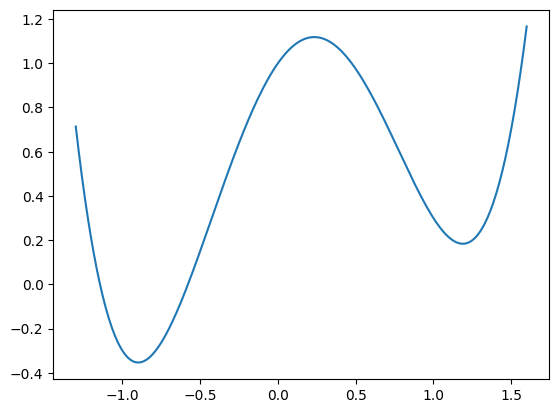

In [4]:
# linspace is range()'s cousin, but for floats 
#   and where the 3rd argument specifies number of steps, not length of steps

x = torch.linspace(-1.3, 1.6, 300)
y = peaks(x)

plt.plot(x, y)
plt.show()

Looks like local minimum values are approximately:
- $x = -0.9$ (global minimum)
- $x = 1.2$ (local minimum)

We can calculate exact values for these points in our graph if we define $x$ and $y$ as tensors and enable their `auto_grad` functionality.

derivatives: tensor([-6.1370, -6.1291, -6.1212, -6.1134, -6.1055])


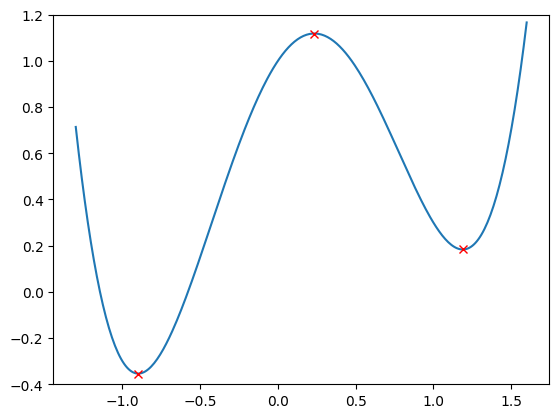

min/max: tensor([-0.8983,  0.2339,  1.1892], grad_fn=<IndexBackward0>) tensor([-0.3536,  1.1185,  0.1835], grad_fn=<IndexBackward0>)


In [5]:
xt = torch.linspace(-1.3, 1.6, 8000, requires_grad=True)
yt = peaks(xt)
yt.backward(torch.ones_like(xt))

dydx = xt.grad
print("derivatives:", dydx[:5])

minmax_idx = (dydx.abs() < 9e-4)
minmax_y = yt[minmax_idx]
minmax_x = xt[minmax_idx]

plt.plot(x, y)
plt.plot(minmax_x.tolist(), minmax_y.tolist(), 'rx')
plt.ylim([-0.4, 1.2])
plt.show()

print("min/max:", minmax_x, minmax_y)

### Wait. What?

Let's look at the individual commands from the cell above.

`xt`: this is a $1D$ tensor of shape $8000$ with value from $-1.3$ to $1.6$.

`yt`: this is a $1D$ tensor of shape $8000$ which holds the results of calling `peaks()` on every value of `xt`.

`yt.backwards(torch.ones_like(xt))`: this calculates the derivatives (slope) of the equation `peak()` for every point of `yt` and `xt`. The `torch.ones_like(xt)` parameter is a bit unconventional and usually we'll just call `backwards()` without any parameters. It's necessary here because instead of asking for the derivative of an equation at one specific point, we want to get the derivatives for all points in our `xt` range tensor.

`dydx = xt.grad`: after calling `backward()` on a tensor (`yt`) that depends on tensors with `requires_grad` (`xt`), the tensors with `requires_grad` will have their gradients/slope store in the `grad` member variable.

`minmax_idx = (dydx.abs() < 9e-4)`: since our function is being evaluated on a discrete set of values inside `xt`, we might not have the exact `xt` that gives an exact slope of $0$, so `dydx.abs() < 9e-4` is a boolean indexing of all values of dydx that are really close to $0$.

`minmax_y = yt[minmax_idx]` and `minmax_x = xt[minmax_idx]`: this gets the actual `x` and `y` values where the slope of `peaks()` is really really close to $0$.

### Solving for min iteratively

Our `peaks()` function is pretty simple, as it only depends on one variable, `x`, and the range we're calculating it over is pretty small, $[-1.2, 1.6]$.

What if our `peaks()` function was more complex and it took minutes to calculate? How can we find its `min` or `max` values?

This is the more common case for `grad` and `backward()`. We evaluate a function once, at one specific input value, and calculate which direction it should move in order to increase or decrease the value of our function.

We can use the `peaks()` function to illustrate. Let's calculate the value of `x` that gives the smallest value for `peaks(x)`.

`xm`: this is the current guess for the value of `x` which gives the smallest value for `peaks()`. We'll initialize it at $0.15$, which is the halfway point of our `x` range.

`xms` and `yms`: these will hold the progression of the `xm` and `ym` variables as they move towards their objectives.

`ym`: the value of `peaks()` at the current `xm`.

`backwards()`: calculate the slope of `ym` with respect to its inputs.

`xm = xm + 0.1 * xm.grad`: update `xm` according to the slope of `peaks()` at `xm`. If the slope is positive, decrease `xm`, if the slope is negative, increase `xm`. This will move `x_m` towards a minimum value of `peaks()`. If we wanted to move towards a maximum value, we increase `xm` for positive slopes and decrease it for negative slopes.

The $0.1$ factor determines how big our steps should be when we update `xm`. There's a tradeoff here: large steps can get to the desired value quicker, but can also totally skip the desired value and end up in some non-desired part of our equation. Small steps, on the other hand, take a little longer to find the objective, but usually converge on the correct value.

`xm.retain_grad()`: again, we're using tensors for educational purposes here, and accumulating gradients in an unconventional way. We have to call this to make sure we can later access the gradient of something that was itself calculated from a gradient. This won't be like this in actual modeling code.

A tensor's `item()` member function just returns that tensor's value as a regular `Python` number. Similarly, if we want to get a tensor as a regular `Python` list we can call its `tolist()` function.

0.15000000596046448 1.1031436920166016 0.3662499785423279


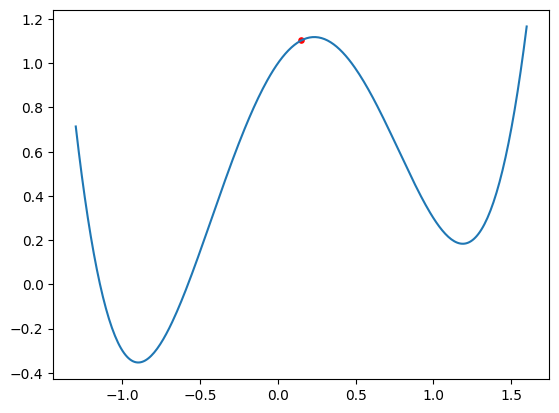

In [6]:
xs = []
ys = []

xm = torch.tensor(0.15, requires_grad=True) # guess and strat from y starting from 0.15

ym = peaks(xm)
ym.backward()

xs.append(xm.item())
ys.append(ym.item())

print(xm.item(), ym.item(), xm.grad.item()) # x, y, slope dydx

plt.plot(x, y)
plt.scatter(xs, ys, marker='o', s=14, c='r')
plt.show()

### Taking steps
- Towards lower value: subtract slope
- To higher value: add slope

0.0950625091791153 1.07646906375885 0.604208767414093


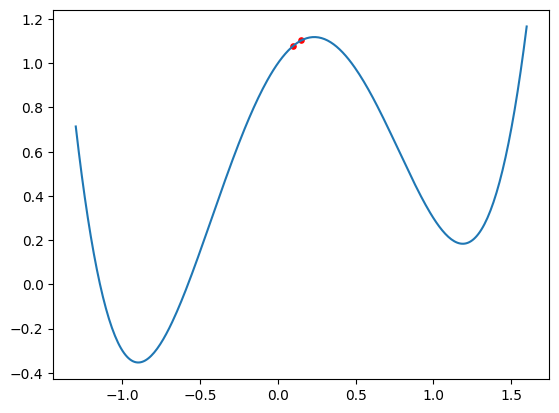

In [7]:
xm = xm - 0.15 * xm.grad
xm.retain_grad()

ym = peaks(xm)
ym.backward()

xs.append(xm.item())
ys.append(ym.item())

print(xm.item(), ym.item(), xm.grad.item())

plt.plot(x, y)
plt.scatter(xs, ys, marker='o', s=14, c='r')
plt.show()

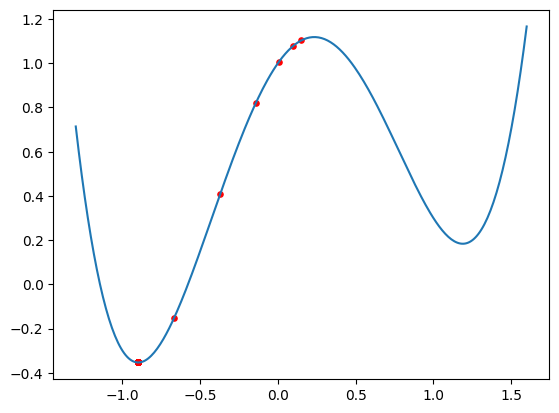

-0.8982061147689819 -0.35361528396606445 4.76837158203125e-07


In [8]:
# TODO: more steps 
for e in range(32):
  xm = xm - 0.15 * xm.grad
  xm.retain_grad()

  ym = peaks(xm)
  ym.backward()

  xs.append(xm.item())
  ys.append(ym.item())

plt.plot(x, y)
plt.scatter(xs, ys, marker='o', s=14, c='r')
plt.show()

print(xm.item(), ym.item(), xm.grad.item())

### X's journey

We saved all of the intermediate values of `xm` and `ym` so we can plot them here:

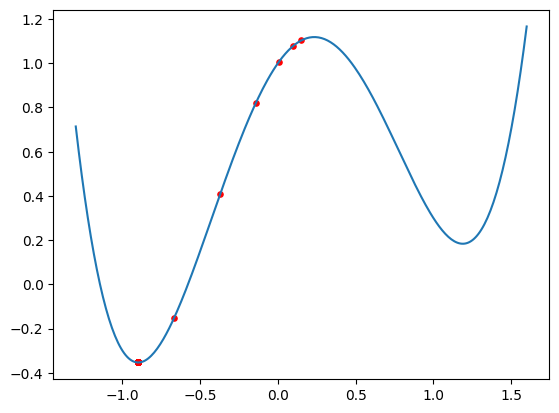

(-0.8982061147689819, -0.35361528396606445)

In [9]:
plt.plot(x, y)
plt.scatter(xs, ys, marker='o', s=14, c='r')
plt.show()
xs[-1], ys[-1]

### Taking all the steps

We took one step. We could loop and take $10$ steps, or take as many steps as are necessary to get to the closest max/min value of our function.

Let's add a loop to the cell above that repeats the following:

- calculate `ym`
- save `xm` and `ym`
- calculate `gradient`
- update `xm`
- repeat

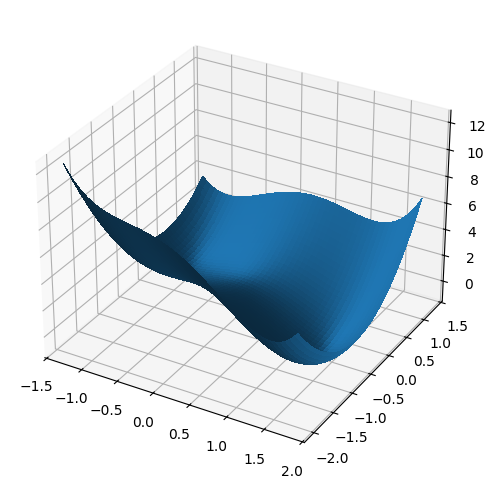

In [10]:
import numpy as np

def cost2d(x,y):
  return x**4 - 0.7*x**3 - 2*x**2 + x*y + 1 + 2*y**2

xs = torch.linspace(-1.3, 1.8, 100).tolist()
ys = torch.linspace(-2, 1.3, 100).tolist()

X, Y = np.meshgrid(xs, ys)
zs = np.array(cost2d(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
plt.show()

tensor([-0.4838,  0.7500])


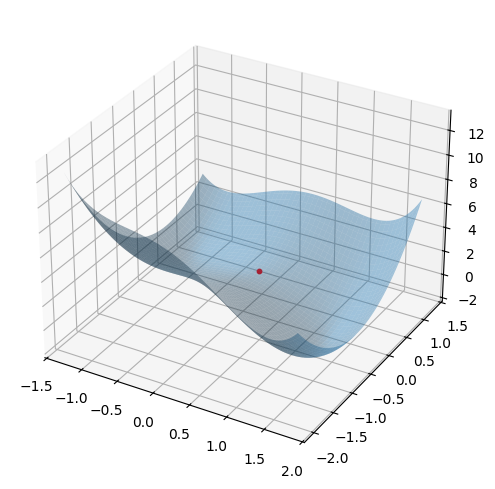

In [11]:
xs = []
ys = []
zs = []

xy = torch.tensor([0.15, 0.15], requires_grad=True)

zm = cost2d(xy[0], xy[1])
zm.backward()

xs.append(xy[0].item())
ys.append(xy[1].item())
zs.append(zm.item())

print(xy.grad)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.4)
ax.scatter(xs, ys, zs, s=10, marker='o', c='r')
plt.show()

[1.3261756896972656, -0.33154362440109253] -1.2768338918685913 None


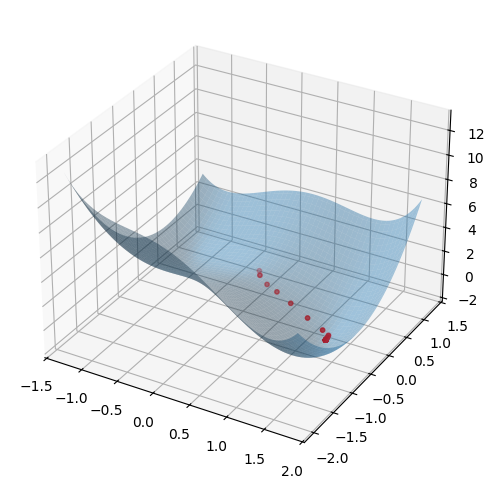

In [25]:
for e in range(32):
  zm = cost2d(xy[0], xy[1])
  zm.backward()

  xs.append(xy[0].item())
  ys.append(xy[1].item())
  zs.append(zm.item())

  xy = xy - 0.1 * xy.grad
  xy.retain_grad()

print(xy.tolist(), zm.item(), xy.grad)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.4)
ax.scatter(xs, ys, zs, s=10, marker='o', c='r')
plt.show()

## Ok, so what ?

Neural Networks is what, because now we have the most important ingredient for training a neural network to perform regression (or classification, or whatever else).

We know how to load data into a `DataFrame`, once we pass this data through a neural network with random values for its parameters, we can calculate the `error` of our cost function in relation to all of the parameters of the network, and then calculate which direction to move all of the parameters to decrease our error.

Let's load the housing prices dataset from `HW03`.

As always, we'll encode and scale our data if needed, and then we'll use the `train_test_split()` function to split our `DataFrame` into $2$ separate datasets, a training dataset with $80\%$ of the rows, and a test dataset with $20\%$.

In [13]:
# Define the location of the json file here
HOUSES_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/LA_housing.json"

houses_info = object_from_json_url(HOUSES_FILE)

houses_raw_df = pd.DataFrame.from_records(houses_info)

house_scaler = StandardScaler()
houses_df = house_scaler.fit_transform(houses_raw_df)

houses_train, houses_test = train_test_split(houses_df, test_size=0.2)

houses_train.head()

,longitude,latitude,age,rooms,bedrooms,value
5652,-1.825674,1.375656,0.134952,0.528728,0.583159,-0.521623
3874,-0.582940,0.545771,-1.179412,-2.162617,0.505147,-1.467811
1442,0.803186,-0.220277,0.322718,0.746208,-0.513806,-0.477189
2052,0.373009,-0.986325,0.322718,0.681159,-0.222055,0.098713
4380,-0.774130,-0.667138,-0.428347,0.551210,0.399688,0.374903


### Create features

Just like with the `LinearRegression` models, we have to separate our independent features and our outcome feature.

This time we put them both into tensors.

The `x` tensor holds all of the independent features for all of the data points, and the `y` tensor their corresponding outcomes (prices).

In [14]:
train_features = houses_train.drop(columns=["value"])
train_values = houses_train["value"]

x_train = Tensor(train_features.values)
y_train = Tensor(train_values.values)

### Define our model

We'll use a very basic neural network model that has an input layer with a neuron for each feature, and a single output neuron for the price prediction.

Something like this:

<img src="./imgs/linear_5x1.jpg" width="800px"/>

Where the initial values for the model parameters are selected at random by default.

We can iterate over out model's parameters and print their shapes, or calculate overall number of parameters using the `numel()` function of each parameter.

In [15]:
model = nn.Linear(len(train_features.columns), 1)

psum = 0

for p in model.parameters():
  print(p.shape)
  psum += p.numel()

print("number of parameters:", psum)

torch.Size([1, 5])
torch.Size([1])
number of parameters: 6


### Test model

We can run this model on our train dataset just to make sure all of our layers have the correct shapes.

If anything is off we'll get an error here.

We're giving our model a `Tensor` with $4623$ houses and $5$ features for each house. It should give us $4623$ predictions.

In [16]:
y = model(x_train)

print("shape of input data:", x_train.shape)
print("shape of output data:", y.shape)
print("first output value", y[0])

shape of input data: torch.Size([4623, 5])
shape of output data: torch.Size([4623, 1])
first output value tensor([-0.5288], grad_fn=<SelectBackward0>)


### Set up training

This will look similar to the iterative approach for finding the minimum value of a function we saw above.

For each step of our iteration we will:

- calculate a price prediction for all of the rows in our dataset
- calculate the overall error for all of the price predictions
- calculate the derivative of this error with respect to the model parameters
- update model parameters to decrease error
- repeat

A few things to note about this process:

1\. We are calculating all of the predictions for all of our data with a single call: `y = model(x)`. `PyTorch` models are smart and they know we want to do the same thing for all of the rows in our data. This optimizes and parallelizes the process.

2\. But... if we take a look at the resulting shape of the call to `model(x)` we'll see that it adds an extra dimension to our predictions, so we have to grab the first column of results with `y[:, 0]`.

3\. The cost function (called `loss` here) is the `L2` distance between all price predictions and all actual prices in our dataset calculated in one go. It's a single number we can take the derivative of. We could skip the square root, but this way our units stay consistent and error is calculated in terms of standard deviations.

4\. The parameters we are optimizing and updating at each iteration aren't our features, but the weights and thresholds of each of our $6$ neurons, which have `requires_grad` turned on by default. At each step we update the model's parameters with `p.data.sub_(p.grad.data * learning_rate)`. This is the very bureaucratic form of doing something like: `p -= p * lr`. Since we are dealing with parameter tensors that keep all kinds of extra information about their values, we have to operate on their `data` members.

5\. Once we have used the parameters' gradients to update our model we have to clear them by calling `grad.zero_()`. We'll see why soon, but by default if we are reusing the same tensors (in this case our model's parameters) we have to make sure they don't accumulate gradients.

In [17]:
learning_rate = 1e-2

for c in range(32):
  y_pred = model(x_train)[:, 0]
  # this is the root mean square error function
  loss = (y_pred - y_train).pow(2).mean().pow(0.5)
  loss.backward()

  for p in model.parameters():
    p.data.sub_(p.grad.data * learning_rate)
    p.grad.zero_()

  if c % 4 == 0:
    print(c, loss.item()) # print the loss every 4 epochs

0 1.3092243671417236
4 1.287989854812622
8 1.267295002937317
12 1.2471448183059692
16 1.2275445461273193
20 1.2084977626800537
24 1.1900080442428589
28 1.1720777750015259


### Interpretation

What's happening in the above cell? 
#### Showing how wrong ? distance between prediction and actual data.

What happens if we keep running it over and over?
#### The loss decreases, meaning the model is getting more accurate (but risking overfitting)

### Checking the train dataset

Once we're happy with the training, we can get predictions for all of our houses in dollars by running the model and reversing the scaling:

In [27]:
y_std = pd.DataFrame(model(x_train).tolist(), columns=["value"])
y_usd = house_scaler.inverse_transform(y_std)

display(y_usd.head())

,value
0,3.561188e+06
1,1.407097e+06
2,2.494758e+06
3,2.794496e+06
4,3.408575e+06


### Growing the Network

The error we were getting above was around $1.0$ standard deviation. That's not bad, but it's also not good.

If we want to improve our model we can try adding layers to our Neural Network. We just have to make sure we add an activation function between the neurons. These are the functions that keep our model parameters within a nice, well-defined, range.

This is how we build the following network:

<img src="./imgs/linear_5x5x1.jpg" width="800px"/>

In [30]:
model2 =  nn.Sequential(
  nn.Linear(len(train_features.columns), len(train_features.columns)),
  nn.Sigmoid(),
  nn.Linear(len(train_features.columns), 1),
)

# TODO: calculate the number of parameters
psum1 = 0

for p in model2.parameters():
  print(p.shape)
  psum1 += p.numel()

print("number of parameters:", psum1)

# TODO: run on train data and check shape of output
y2 = model2(x_train)

print("shape of input data:", x_train.shape)
print("shape of output data:", y2.shape)
print("first output value", y2[0])

torch.Size([5, 5])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
number of parameters: 36
shape of input data: torch.Size([4623, 5])
shape of output data: torch.Size([4623, 1])
first output value tensor([-0.3153], grad_fn=<SelectBackward0>)


### So... many... parameters

How many parameters do we have now? We might not want to keep updating them ourselves.

Relying on a for loop to get all the parameters and remembering to call `grad.zero_()` at the right time is just prone to errors and inefficiencies.

Luckily, `PyTorch` has some optimizers we can use. They usually take our model as an input, along with some other parameters, and give us a simpler interface to control the optimization process.

### Initialize Optimizer

We're going to use one of the simpler optimizers to performs [_stochastic gradient descent_](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Gradient descent is the official name of the algorithm that calculates which way to update our parameters given the slope of our cost function and a learning rate. _Stochastic_ means that it should still work if we sub-sample our input data and only use a subset of the data points at a time. It remembers/accumulates information about previous error measurements.

The documentation for the [`SGD` optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) has more info about the algorithm and the parameters it takes.

Other than simplifying our training code, these pre-built optimizers also perform dynamic learning rate adjustment and some other tricks that make our overall process not so sensitive to an exact learning rate.

The `PyTorch` library also has a number of [other optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) useful for performing gradient descent. In addition to `SGD()` we can also try [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) or [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html).

In [20]:
learning_rate = 2e-1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train it

We can train our new model, just like before, except now the training loop should be a little bit simpler.

We still have to call `zero_grad()`, but only on the optimizer. It will take care of clearing the gradients for each of the model's parameters for us.

And, after we calculate the slope of our cost function, we call `optim.step()`, so the optimizer can update the parameters with a new slope value.

In [21]:
for c in range(32):
  optim.zero_grad()
  y_pred = model(x_train)[:, 0]
  loss = (y_pred - y_train).pow(2).mean().pow(0.5)
  loss.backward()
  optim.step()

  if c % 4 == 0:
    print(c, loss.item())

0 1.0971267223358154
4 0.9948451519012451
8 0.9838455319404602
12 0.9740892648696899
16 0.9642249345779419
20 0.9541218876838684
24 0.9437171816825867
28 0.9330019950866699


### Test dataset

We can still adjust a lot of parameters here, but before we spend too much time on this model, let's run it on the test dataset and calculate the average loss on data that wasn't used for training to see if the model is over-fitting.

We'll load the test data, run the mode and calculate loss.

In [22]:
test_features = houses_test.drop(columns=["value"])
test_values = houses_test["value"]

x_test = torch.Tensor(test_features.values)
y_test = torch.Tensor(test_values.values)

### `no_grad()`

We can call the `torch.no_grad()` function to tell `PyTorch` to momentarily stop calculating slopes/gradients when we are not training and just want to use the model to predict prices. We do this by creating a block of code where our model runs faster and more carefree.

In [23]:
with torch.no_grad():
  y_pred = model(x_test).reshape(-1)
  loss = (y_pred - y_test).pow(2).mean().pow(0.5)
  print(loss.item())

0.9091435074806213


### Interpretation

This isn't bad.

The absolute value of the error is kind of large, but the test dataset error is comparable to the training dataset error, which is a good indication that the model is not over-fitting.

And it seems to be learning, so let's tune it.

### Hyperparameters

We can spend some time adjusting the model, adding layers, changing the optimizer, the learning rate, experimenting with the optimizer's parameters, etc.

This process is usually referred to as hyperparameter tuning, since we're picking parameters that will help us calculate the parameters of our neural network.

Here's a cell with all of the steps combined. We can play with the network architecture and parameters here.

In [ ]:
## Define Model
model =  nn.Sequential(
  nn.Linear(len(train_features.columns), len(train_features.columns)),
  nn.Sigmoid(),

  # TODO: add layers ?

  nn.Linear(len(train_features.columns), 1),
)

# calculate the number of parameters
psum = 0

for p in model.parameters():
  print(p.shape)
  psum += p.numel()

print("number of parameters:", psum)


## Define Optimizer
learning_rate = 5e-1
# TODO: adjust parameters, add parameters, change optimizer
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Load Data
x_train = torch.Tensor(train_features.values)
y_train = torch.Tensor(train_values.values)
x_test = torch.Tensor(test_features.values)
y_test = torch.Tensor(test_values.values)

## Train Model
for c in range(128):
  optim.zero_grad()
  y_pred = model(x_train).reshape(-1)
  loss = (y_pred - y_train).pow(2).mean().pow(0.5)
  loss.backward()
  optim.step()

  if c % 16 == 0:
    print(c, loss.item())

## Evaluate Model
with torch.no_grad():
  y_pred = model(x_train).reshape(-1)
  loss_train = (y_pred - y_train).pow(2).mean().pow(0.5)

  y_pred = model(x_test).reshape(-1)
  loss_test = (y_pred - y_test).pow(2).mean().pow(0.5)

  print("\ntrain loss:", loss_train.item(), "\ntest loss:", loss_test.item())

torch.Size([5, 5])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
number of parameters: 36
0 1.0305280685424805
16 0.9008088111877441
32 0.8118382096290588
48 0.785183310508728
64 0.779800295829773
80 0.7778274416923523
96 0.7762221693992615
112 0.7744743227958679

train loss: 0.7724090814590454 
test loss: 0.7749382853507996


### Interpretation

Our model is definitely learning, but it doesn't seem like naively adding layers will improve the model. It might take a moment to tune and train before we get something comparable to the `LinearRegression` model, but that's not entirely surprising.

Usually what makes the biggest difference in these kinds of models is the size of the training dataset, compared to the number of parameters the model has to learn.

Some of the same tricks we used for the `LinearRegression` model could also help here. In theory the neural network should learn how to combine parameters into polynomial features, and also how to combine features akin to `PCA`, but sometimes it needs a little push in the right direction.